Loaded 15 valid .npz files
Codebook size: torch.Size([256, 128])


Epoch 49: 100%|██████████| 2/2 [00:04<00:00,  2.03s/it, loss=1.25e+3]


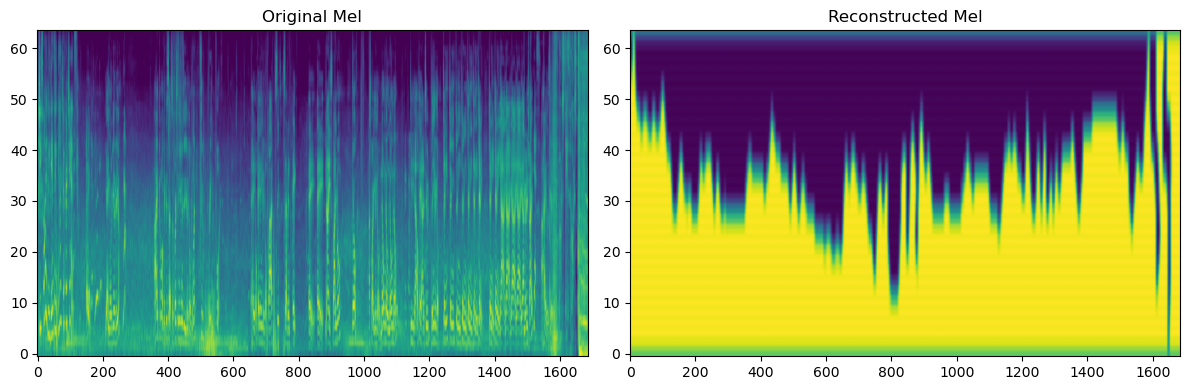

In [7]:
import os
import glob
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# ===========================
# 1. Dataset + DataLoader
# ===========================
class MelSpectrogramDataset(Dataset):
    def __init__(self, folder):
        self.files = sorted(glob.glob(os.path.join(folder, "*.npz")))
        self.valid_files = []
        for f in self.files:
            data = np.load(f)
            if 'mel' in data:
                mel = data['mel']
                if mel.shape[1] >= 1685:
                    self.valid_files.append(f)
        print(f"Loaded {len(self.valid_files)} valid .npz files")

    def __len__(self):
        return len(self.valid_files)

    def __getitem__(self, idx):
        path = self.valid_files[idx]
        mel = np.load(path)['mel'][:, :1685]
        mel = (mel - mel.mean()) / (mel.std() + 1e-6)  # Normalize
        mel = torch.tensor(mel, dtype=torch.float32)
        return mel

# ===========================
# 2. VQ-VAE Model
# ===========================
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost

        self.embeddings = nn.Embedding(self.num_embeddings, self.embedding_dim)
        self.embeddings.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)

    def forward(self, z):
        flat_z = z.permute(0, 2, 3, 1).contiguous().view(-1, self.embedding_dim)
        distances = (flat_z ** 2).sum(1, keepdim=True) - 2 * flat_z @ self.embeddings.weight.t() + (self.embeddings.weight ** 2).sum(1)
        encoding_indices = torch.argmin(distances, dim=1)
        quantized = self.embeddings(encoding_indices).view(z.shape[0], z.shape[2], z.shape[3], self.embedding_dim).permute(0, 3, 1, 2)

        e_latent_loss = F.mse_loss(quantized.detach(), z)
        q_latent_loss = F.mse_loss(quantized, z.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        quantized = z + (quantized - z).detach()
        return quantized, loss

class VQVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        )
        self.vq = VectorQuantizer(num_embeddings=256, embedding_dim=128, commitment_cost=0.25)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x):
        z = self.encoder(x)
        z_q, vq_loss = self.vq(z)
        x_recon = self.decoder(z_q)
        return x_recon, vq_loss

# ===========================
# 3. Training Loop + Logging
# ===========================
folder = "C:/Users/neela/OneDrive/Documents/ucfReuDataset"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = MelSpectrogramDataset(folder)
loader = DataLoader(dataset, batch_size=8, shuffle=True)
model = VQVAE().to(device)

# ✅ Now that the model exists, we can print the codebook size
print("Codebook size:", model.vq.embeddings.weight.shape)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()
writer = SummaryWriter()

for epoch in range(50):
    model.train()
    loop = tqdm(loader, total=len(loader))
    for i, mel in enumerate(loop):
        mel = mel.unsqueeze(1).to(device)

        recon, vq_loss = model(mel)
        if recon.shape[-1] != mel.shape[-1]:
            diff = mel.shape[-1] - recon.shape[-1]
            if diff > 0:
                recon = F.pad(recon, (0, diff), mode='constant', value=0)
            else:
                recon = recon[:, :, :, :mel.shape[-1]]

        recon_loss = loss_fn(recon, mel)
        loss = recon_loss + vq_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        writer.add_scalar("Loss/total", loss.item(), epoch * len(loader) + i)
        writer.add_scalar("Loss/recon", recon_loss.item(), epoch * len(loader) + i)
        writer.add_scalar("Loss/vq", vq_loss.item(), epoch * len(loader) + i)

        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())

# ===========================
# 4. Visualization
# ===========================
model.eval()
sample = random.choice(dataset)
sample_tensor = sample.unsqueeze(0).unsqueeze(0).to(device)
recon, _ = model(sample_tensor)
recon = recon.squeeze().cpu().detach().numpy()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Original Mel")
plt.imshow(sample.numpy(), aspect='auto', origin='lower')
plt.subplot(1, 2, 2)
plt.title("Reconstructed Mel")
plt.imshow(recon, aspect='auto', origin='lower')
plt.tight_layout()
plt.show()


In [2]:
%load_ext tensorboard
%tensorboard --logdir=runs


Reusing TensorBoard on port 6007 (pid 30280), started 12:59:30 ago. (Use '!kill 30280' to kill it.)